In [1]:
import pandas as pd
import numpy as np
import os
import boto3
import seaborn as sns
import matplotlib.pyplot as plt
from sagemaker import get_execution_role

Set up region/bucket

In [2]:
my_region = boto3.session.Session().region_name

print("region: {}".format(my_region))

region: us-east-1


In [3]:
s3 = boto3.resource('s3')
bucket_name = 'tech-x-final-project'

In [4]:
try:
    if  my_region == 'us-east-1':
        if not s3.Bucket(bucket_name).creation_date:
            s3.create_bucket(Bucket=bucket_name)
            print('S3 bucket created successfully')
        else:
            print('Bucket already exists!')
    else: 
        if not s3.Bucket(bucket_name).creation_date:
            s3.create_bucket(Bucket=bucket_name, CreateBucketConfiguration={'LocationConstraint': my_region})
            print('S3 bucket created successfully')
        else:
            print('Bucket already exists!')
except Exception as e:
    print('S3 error: ', e)

Bucket already exists!


In [5]:
DATASET = 'train.csv'
MAIN_FOLDER = 's3://tech-x-final-project'
DATA_FOLDER = 'raw-data'
OUT_FOLDER = 'clean-data'

Training data had errors, updated with the train_updates_20220929.csv file

Complete pre-processing for provided updates/corrections to training_data
(Note: code adapted from competition site code for utilizing update file)

In [6]:
df_train = pd.read_csv(os.path.join(MAIN_FOLDER,DATA_FOLDER,DATASET), index_col="seq_id")
df_train_updates = pd.read_csv(os.path.join(MAIN_FOLDER,DATA_FOLDER,"train_updates_20220929.csv"), index_col="seq_id")
all_features_nan = df_train_updates.isnull().all("columns")

drop_indices = df_train_updates[all_features_nan].index
df_train = df_train.drop(index=drop_indices)
swap_ph_tm_indices = df_train_updates[~all_features_nan].index
df_train.loc[swap_ph_tm_indices, ["pH", "tm"]] = df_train_updates.loc[swap_ph_tm_indices, ["pH", "tm"]]

Basic EDA (I did more, but I cleaned it up a bit)

Also, turns out there's some data cleaning to do...

In [7]:
df_train.shape

(28981, 4)

In [8]:
df_train.head()

,protein_sequence,pH,data_source,tm
seq_id,,,,
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5


In [9]:
df_train = df_train.reset_index().drop('seq_id', axis=1)
df_train.head()

,protein_sequence,pH,data_source,tm
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5


In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28981 entries, 0 to 28980
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   protein_sequence  28981 non-null  object 
 1   pH                28695 non-null  float64
 2   data_source       28001 non-null  object 
 3   tm                28981 non-null  float64
dtypes: float64(2), object(2)
memory usage: 905.8+ KB


In [11]:
df_train.isnull().any()

protein_sequence    False
pH                   True
data_source          True
tm                  False
dtype: bool

In [12]:
# Check for & remove duplicates - there are a few
print(len(df_train))
df_train = df_train.drop_duplicates()
print(len(df_train))

28981
28973


In [13]:
df_train.describe()

,pH,tm
count,28687.000000,28973.000000
mean,6.872582,51.360494
std,0.792910,12.057844
min,1.990000,25.100000
25%,7.000000,43.600000
50%,7.000000,48.800000
75%,7.000000,54.600000
max,11.000000,130.000000


In [14]:
df_train.isnull().sum()

protein_sequence      0
pH                  286
data_source         972
tm                    0
dtype: int64

In [15]:
# Some pH data is missing
df_train.isnull().any()

protein_sequence    False
pH                   True
data_source          True
tm                  False
dtype: bool

In [16]:
df_train.head()

,protein_sequence,pH,data_source,tm
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5


In [17]:
df_train.groupby(['data_source']).count()

,protein_sequence,pH,tm
data_source,,,
10.1002/(sici)1097-0134(19980301)30:4<401::aid-prot7>3.0.co;2-l,4,4,4
10.1002/(sici)1097-0134(19990215)34:3<303::aid-prot4>3.0.co;2-h,1,1,1
10.1002/bip.1981.360200921,5,5,5
10.1002/bip.360261104,4,4,4
10.1002/bip.360321103,10,10,10
...,...,...,...
10.1529/biophysj.106.103804,10,10,10
10.2210/pdb1l16/pdb,2,2,2
10.7554/eLife.34729,30,30,30


In [18]:
# Note: duplicate protein_sequences (total n > 27375)
df_train.nunique()

protein_sequence    27375
pH                    104
data_source           324
tm                    725
dtype: int64

Look at distribution of pH

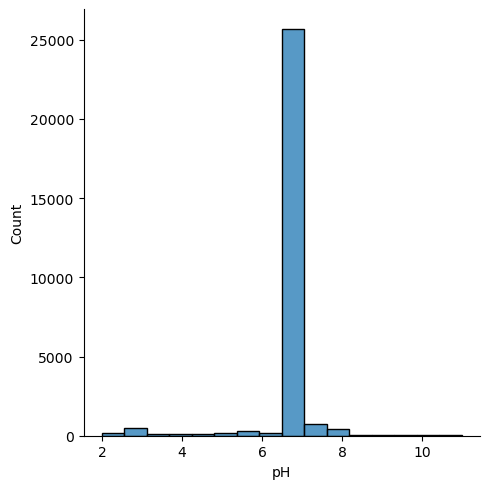

In [19]:
sns.displot(df_train.pH)

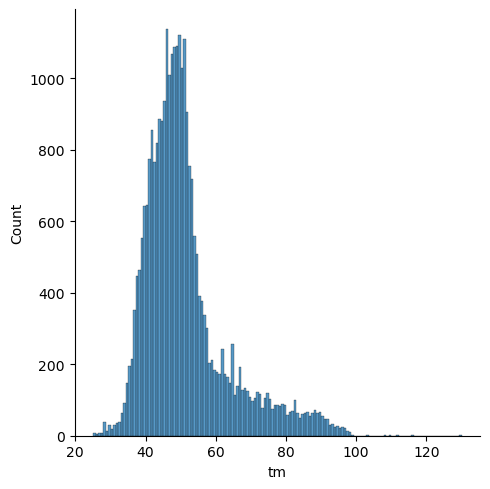

In [20]:
sns.displot(df_train.tm)

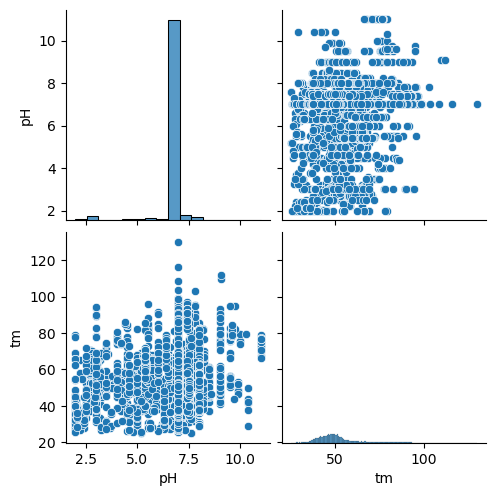

In [21]:
sns.pairplot(df_train)

pH is really unbalanced, and protein-sequence has duplicates. Look into making a problem sub-set by considering only items with pH of 7

In [22]:
df_train1 = df_train[df_train.pH.between(6.0, 8.0, inclusive='both')]
print(df_train.shape, df_train1.shape)
print(df_train1.nunique())

(28973, 4) (26990, 4)
protein_sequence    26318
pH                     21
data_source           190
tm                    712
dtype: int64


In [23]:
# Still duplicate protein_sequences, Look at tm for those.  Results show some highly variable (high standard dev.) tm values
tmp = df_train1.groupby('protein_sequence').std().sort_values('tm', ascending=False)
print(tmp.head(15))
print(len(df_train1))

                                                          pH         tm
protein_sequence                                                       
MLSRAVCGTSRQLAPVLGYLGSRQKHSLPDLPYDYGALEPHINAQIM...  0.000000  22.980970
MPEKSLYEMAVEQFNRAASLMDLESDLAEVLRRPKRVLIVEFPVRMD...  0.000000  22.556706
MSSKEQKTPEGQAPEEIIMDQHEEIEAVEPEASAEQVDPRDEKVANL...  0.000000  21.920310
MERYESLFAQLKERKEGAFVPFVTLGDPGIEQSLKIIDTLIEAGADA...  0.000000  19.798990
MRNTGAGPSPSVSRPPPSAAPLSGAALAAPGDAPSALYAPSALGLTV...  0.707107  19.586858
MRNTGAGPSPSVSRPPPSAAPLSGAALAAPGDAPSALYAPSALVLTV...  0.070711  19.516147
MKIKTGARILALSALTTMMFSASALAKIEEGKLVIWINGDKGYNGLA...  0.472582  19.313985
MPEKSLYEMAVEQFNRAASLMDLESDLAEVLRRPKRVLIVEFPVRMD...  0.000000  19.237550
MKIKTGARILALSALTTMMFSASALAKIEEGKLVIWINGDKGYNGLA...  0.472582  18.251667
MQRGKVKWFNSEKGYGFIEVEGGSDVFVHFTAIQGEGFKTLEEGQEV...  0.000000  18.244269
MMSFVSLLLVGILFHATQAEQLTKCEVFRELKDLKGYGGVSLPEWVC...  0.000000  18.101934
MSKKIGLFYGTQTGKTESVAEIIRDEFGNDVVTLHDVSQAEVTDLND...  0.000000  17

/tmp/ipykernel_22680/2420568783.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = df_train1.groupby('protein_sequence').std().sort_values('tm', ascending=False)


Since some of these tm values vary pretty wildly, we'll start WITHOUT the ones that have different measurements.

In [24]:
cnts = df_train1.groupby('protein_sequence').count()
drops = cnts[cnts.tm > 1].reset_index()
print(drops.head(),"\n", len(drops))
drops  = list(drops.protein_sequence)
# drops = list(drops.protein_sequence)
print(len(df_train1))
df = df_train1[~df_train1.protein_sequence.isin(drops)]
print(len(df))

                                    protein_sequence  pH  data_source  tm
0  DTSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVVFQNRESVLPT...   3            1   3
1  DVSGTVCLSALPPEATDTLNLIASDGPFPYSQAGVVFQNRESVLPT...   2            1   2
2  DVSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVTFQNRESVLPT...   3            1   3
3  DVSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVVFANRESVLPT...   4            1   4
4  DVSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVVFQARESVLPT...   3            1   3 
 456
26990
25862


In [25]:
# print(df.shape)
# print(df.nunique())
# df = df.drop(['pH','data_source'], axis=1)
# df.to_csv(os.path.join(file_loc,"clean_data.csv"))

In [26]:
dfout = df.drop('data_source',axis=1)
dfout.head()
dfout = dfout.rename(columns={'tm':'label'})
# dfout = dfout[['label','protein_sequence']]

In [27]:
dfout.head()

,protein_sequence,pH,label
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5


In [28]:
# Make Test/Train split
train_data, test_data = np.split(dfout.sample(frac=1, random_state=1729), [int(0.8 * len(dfout)),])
print(len(dfout), len(train_data), len(test_data))


25862 20689 5173


In [29]:


train_data.to_csv(os.path.join(MAIN_FOLDER,OUT_FOLDER,'clean_train.csv'), index=False, header=False)
test_data.to_csv(os.path.join(MAIN_FOLDER,OUT_FOLDER,'clean_test.csv'), index=False, header=False)
# boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(MAIN_FOLDER,OUT_FOLDER,'cleana.csv')).upload_file('cleana.csv')
# s3_input_train = sagemaker.TrainingInput(s3_data='s3://{}/{}/clean-data'.format(bucket_name, OUT_FOLDER), content_type='text/csv')

In [30]:
train_data.head()

,protein_sequence,pH,label
7896,MDSDYIFHNGDDIRNMGLEEMRRQKVLLASELKAIDAQISDLAFNN...,7.0,38.5
6006,MASINLIKSLKLYKEKIWSFDFSQGILATGSTDRKIKLVSVKYDDF...,7.0,48.4
19171,MQHSSMKVDLSNFFKDERRNSLVFIDAAWNNIKDLQDHIQNLFSLK...,7.0,41.6
15125,MLRRMNTFSGQKLAAVVKELENFAPTSWAEKWDNVGLLIEPHREKQ...,7.0,52.7
28135,SPIENLFKYRAVKASHSKNINSTLPAWNGSNSSNVTYANGTNSTTN...,7.0,53.4


In [60]:
# s3.meta.client.upload_file(Filename = 'clean.csv', Bucket= bucket_name, Key = 'clean.csv')

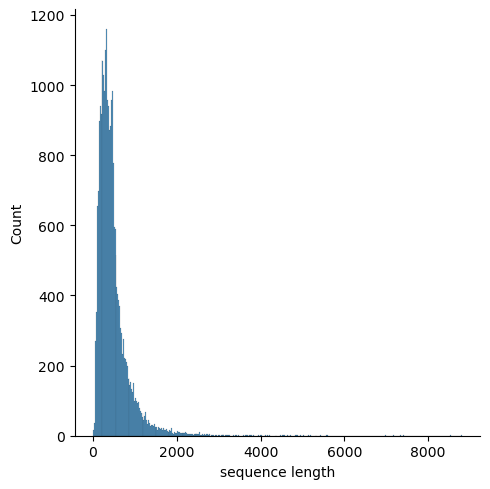

In [61]:
#Some EDA on the sequence length
dfout['sequence length'] = dfout['protein_sequence'].map(len)

sns.displot(dfout['sequence length'])

In [62]:
dfout['sequence length'].describe()

count    25862.000000
mean       478.919302
std        425.116676
min          5.000000
25%        239.000000
50%        378.000000
75%        568.000000
max       8798.000000
Name: sequence length, dtype: float64

In [63]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer='char', ngram_range=(1,1))
 
term_matrix = vectorizer.fit_transform(dfout.protein_sequence)
features = vectorizer.get_feature_names_out()


In [64]:
# print(features)
# print(len(features))

In [65]:
#OUTPUT features for autoML
# import Features_Modules as fm

# df = fm.read_clean_data()
# model_data, features, scaler = fm.pre_process_data(df, [(1,2)])
# model_data.head()

In [66]:
model_data.to_csv(os.path.join(MAIN_FOLDER,"automl","training2.csv"))

In [67]:
model_data.head()

,a,aa,ac,ad,ae,af,ag,ah,ai,ak,...,yp,yq,yr,ys,yt,yv,yw,yy,length,label
0,0.252957,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.333862,75.7
1,-0.256378,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.461421,50.5
2,0.402761,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.027940,40.5
3,-0.496065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.510125,47.2
4,1.481352,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.240498,49.5
